In [1]:
import torch
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load YOLOv5 model for animal detection
animal_model = torch.hub.load('ultralytics/yolov5', 'yolov5x')

# Expanded Animal Classes Dictionary
animal_classes = {
    14: "bird", 15: "cat", 16: "dog", 17: "horse", 18: "sheep", 19: "cow", 20: "elephant",
    21: "bear", 22: "zebra", 23: "giraffe", 24: "rabbit", 25: "fox", 26: "tiger", 27: "lion",
    28: "kangaroo", 29: "whale", 30: "dolphin", 31: "camel", 32: "crocodile", 33: "panda",
    34: "owl", 35: "parrot", 36: "pelican", 37: "swan", 38: "monkey", 39: "chimpanzee",
    40: "goat", 41: "deer", 42: "llama", 43: "albatross", 44: "bat", 45: "starling",
    46: "sparrow", 47: "woodpecker", 48: "duck", 49: "beetle", 50: "wolf", 51: "buffalo",
    52: "otter", 53: "porcupine", 54: "raccoon", 55: "skunk", 56: "squirrel", 57: "koala",
    58: "hedgehog", 59: "peacock", 60: "jaguar", 61: "cheetah", 62: "hippopotamus"
}

# Function to Detect Animals
def contains_animal(image_path, confidence_threshold=0.5):
    img = Image.open(image_path).convert('RGB')
    img = np.array(img)
    results = animal_model(img)
    pred_classes = results.xywh[0][:, -1].tolist()
    pred_confidences = results.xywh[0][:, 4].tolist()
    
    for class_id, confidence in zip(pred_classes, pred_confidences):
        if class_id in animal_classes and confidence >= confidence_threshold:
            return True
    return False

# Fire Detection using VGG19
train_dir = 'dataset/fire_dataset'
val_dir = 'dataset/test_dataset/Our_Dataset_610'
img_height, img_width = 224, 224
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.3, height_shift_range=0.3,
    shear_range=0.3, zoom_range=0.3, brightness_range=[0.7, 1.3], fill_mode='nearest')

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

validation_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='binary')

# Load Pre-trained VGG19 Model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers[:-5]:  # Unfreeze last 5 layers
    layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduler and Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the Model
model.fit(
    train_generator, steps_per_epoch=train_generator.samples // batch_size, epochs=10,
    validation_data=validation_generator, validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping, lr_scheduler])

model.save('fire_detection_vgg19.keras')

# Fire Prediction Function
def contains_fire(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return prediction[0][0] < 0.5

# Final Check Function
def check_fire_and_animal(image_path):
    fire_detected = contains_fire(image_path)
    animal_detected = contains_animal(image_path)
    if fire_detected and animal_detected:
        print("Fire detected near an animal!")
    elif fire_detected:
        print("Fire detected, no animal present.")
    elif animal_detected:
        print("No fire, but an animal is present.")
    else:
        print("No fire and no animal detected.")



Using cache found in C:\Users\Lenovo/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-1-5 Python-3.12.7 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 


Found 1000 images belonging to 2 classes.
Found 593 images belonging to 2 classes.
Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 657s 21s/step - accuracy: 0.6897 - loss: 0.6602 - val_accuracy: 0.8194 - val_loss: 0.4552 - learning_rate: 1.0000e-04
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7500 - loss: 0.4680 - val_accuracy: 0.8229 - val_loss: 0.4725 - learning_rate: 1.0000e-04
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 607s 20s/step - accuracy: 0.8498 - loss: 0.3396 - val_accuracy: 0.8351 - val_loss: 0.5654 - learning_rate: 1.0000e-04
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9688 - loss: 0.1978 - val_accuracy: 0.8333 - val_loss: 0.5768 - learning_rate: 1.0000e-04
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 600s 19s/step - accuracy: 0.9132 - loss: 0.2287 - val_accuracy: 0.8368 - val_loss: 1.6509 - learning_rate: 5.0000e-05
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9375 - loss: 0.0853 - val_accuracy: 0.8420 - val_loss: 1.8642 - learning_rate

In [3]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Sample ground truth (y_true) and predicted values (y_pred)
# 1 = Fire/Animal Present, 0 = Fire/Animal Absent
y_true_fire = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0])  # True labels for fire detection
y_pred_fire = np.array([1, 0, 1, 0, 0, 1, 1, 0, 1, 0])  # Predicted labels for fire detection

y_true_animal = np.array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1])  # True labels for animal detection
y_pred_animal = np.array([0, 1, 1, 0, 1, 0, 0, 1, 1, 1])  # Predicted labels for animal detection

# Function to calculate and display performance metrics
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"\nPerformance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

# Evaluate Fire Detection Model
evaluate_model(y_true_fire, y_pred_fire, "Fire Detection")

# Evaluate Animal Detection Model
evaluate_model(y_true_animal, y_pred_animal, "Animal Detection")



Performance Metrics for Fire Detection:
Accuracy: 0.8000
Precision: 0.8000
Recall: 0.8000
F1-Score: 0.8000
ROC-AUC Score: 0.8000
Confusion Matrix:
[[4 1]
 [1 4]]

Performance Metrics for Animal Detection:
Accuracy: 0.8000
Precision: 0.8333
Recall: 0.8333
F1-Score: 0.8333
ROC-AUC Score: 0.7917
Confusion Matrix:
[[3 1]
 [1 5]]


In [1]:
# Install required dependencies if not installed
!pip install torch torchvision tensorflow opencv-python pillow matplotlib

import tensorflow as tf
import torch
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# ========== 1️⃣ Load Dataset (Already Extracted) ==========
data_dir = r'C:\Users\Lenovo\Desktop\New project\new code fire dataset\dataset\fire_dataset'  # Provide the extracted dataset folder

# Load images as TensorFlow dataset
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
)

# Normalize images (Convert pixel values to range [0, 1])
data = data.map(lambda x, y: (x / 255.0, y))

# ========== 2️⃣ Split Dataset ==========
data_size = len(list(data))
train_size = int(data_size * 0.7)  # 70% for training
val_size = int(data_size * 0.2)    # 20% for validation
test_size = int(data_size * 0.1)   # 10% for testing

train_data = data.take(train_size)
remaining = data.skip(train_size)
val_data = remaining.take(val_size)
test_data = remaining.skip(val_size).take(test_size)

# ========== 3️⃣ Load Pre-trained VGG19 Model ==========
base_model = tf.keras.applications.VGG19(
    weights="imagenet", include_top=False, input_shape=(256, 256, 3)
)
base_model.trainable = False  # Freeze the base model

# Define new model for fire detection
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ========== 4️⃣ Train the Model ==========
epochs = 20  # Adjust as needed
history = model.fit(train_data, validation_data=val_data, epochs=epochs)

# Save trained weights
model.save_weights('fire_model_vgg19.weights.h5')
print("✅ Model weights saved as fire_model_vgg19.weights.h5")

# ========== 5️⃣ Load YOLOv5 for Animal Detection ==========
def load_animal_model():
    try:
        return torch.hub.load('ultralytics/yolov5', 'yolov5x')
    except Exception as e:
        print(f"Error loading YOLOv5 model: {e}")
        return None

animal_model = load_animal_model()

# Animal classes dictionary
animal_classes = {
    14: "bird", 15: "cat", 16: "dog", 17: "horse", 18: "sheep", 19: "cow", 20: "elephant",
    21: "bear", 22: "zebra", 23: "giraffe", 24: "rabbit", 25: "fox", 26: "tiger", 27: "lion",
    28: "kangaroo", 29: "whale", 30: "dolphin", 31: "camel", 32: "crocodile", 33: "panda"
}

# Load trained fire model
def load_fire_model():
    try:
        base_model = tf.keras.applications.VGG19(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
        base_model.trainable = False  # Freeze the base model

        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.load_weights('fire_model_vgg19.weights.h5')  # Load trained weights
        return model
    except Exception as e:
        print(f"Error loading fire detection model: {e}")
        return None

fire_model = load_fire_model()

# ========== 6️⃣ Define Prediction Functions ==========

# Detect fire in an image
def detect_fire(image):
    try:
        img_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return fire_model.predict(img_array)[0][0]
    except Exception as e:
        print(f"Error in fire detection: {e}")
        return 1  # Default to no fire detected

# Detect animals in an image
def contains_animal(image, confidence_threshold=0.5):
    try:
        img = np.array(image)
        results = animal_model(img)
        pred_classes = results.xywh[0][:, -1].tolist()
        pred_confidences = results.xywh[0][:, 4].tolist()

        for class_id, confidence in zip(pred_classes, pred_confidences):
            if class_id in animal_classes and confidence >= confidence_threshold:
                return True
        return False
    except Exception as e:
        print(f"Error in animal detection: {e}")
        return False

# ========== 7️⃣ Process Image & Predict ==========
def process_image(image_path):
    image = Image.open(image_path).resize((256, 256))

    fire_prediction = detect_fire(image)
    animal_detected = contains_animal(image)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Print detection results
    print("\n🔍 Detection Results:")
    if fire_prediction < 0.5 and animal_detected:
        print("🔥 Fire detected near animals!")
    elif fire_prediction < 0.5:
        print("🔥 Fire detected.")
    elif animal_detected:
        print("🐾 Animals detected but no fire.")
    else:
        print("✅ No fire or animals detected.")




DEPRECATION: Loading egg at c:\users\lenovo\anaconda3\lib\site-packages\mask_rcnn-2.1-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Found 1000 files belonging to 2 classes.
Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step - accuracy: 0.6683 - loss: 3.0829 - val_accuracy: 0.8750 - val_loss: 0.4102
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 166s 7s/step - accuracy: 0.8723 - loss: 0.3345 - val_accuracy: 0.8802 - val_loss: 0.2366
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 156s 7s/step - accuracy: 0.9148 - loss: 0.2254 - val_accuracy: 0.8906 - val_loss: 0.2399
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 157s 7s/step - accuracy: 0.9225 - loss: 0.1888 - val_accuracy: 0.9375 - val_loss: 0.1576
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.9472 - loss: 0.1446 - val_accuracy: 0.9219 - val_loss: 0.1807
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - accuracy: 0.9401 - loss: 0.1510 - val_accuracy: 0.9531 - val_loss: 0.1280
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - accuracy: 0.9578 - loss: 0.1143 - val_accuracy: 0.8958 - val_loss: 0.2273
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 167s 8s/step - accuracy: 0.9309 

Using cache found in C:\Users\Lenovo/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-1-5 Python-3.12.7 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 


FileNotFoundError: [Errno 2] No such file or directory: 'test_image.jpg'

In [ ]:
def process_image(image_path):
    image = Image.open(image_path).resize((256, 256))

    fire_prediction = detect_fire(image)
    animal_detected = contains_animal(image)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Print detection results
    print("\n🔍 Detection Results:")
    if fire_prediction < 0.5 and animal_detected:
        print("🔥 Fire detected near animals!")
    elif fire_prediction < 0.5:
        print("🔥 Fire detected.")
    elif animal_detected:
        print("🐾 Animals detected but no fire.")
    else:
        print("✅ No fire or animals detected.")


In [11]:
import tensorflow as tf
import os
import zipfile
import numpy as np
import torch
import cv2
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display


train_zip_path = "archive (4).zip"  
test_zip_path = "archive.zip"  


train_extract_path = "dataset"
test_extract_path = "test_data"

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_extract_path)

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)


train_data_dir = os.path.join(train_extract_path, 'fire_dataset')
test_data_dir = os.path.join(test_extract_path, 'Our_Dataset_610')

train_data = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
)


test_data = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32,
)

# Normalize datasets
train_data = train_data.map(lambda x, y: (x / 255.0, y))
test_data = test_data.map(lambda x, y: (x / 255.0, y))

# Split train dataset into train and validation
data_size = len(list(train_data))
train_size = int(data_size * 0.7)
val_size = int(data_size * 0.2)

train_dataset = train_data.take(train_size)
remaining = train_data.skip(train_size)
val_dataset = remaining.take(val_size)

# Load VGG19 as base model
base_model = tf.keras.applications.VGG19(
    weights="imagenet", include_top=False, input_shape=(256, 256, 3)
)
base_model.trainable = False

# Define model architecture
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 5  # Adjust as needed
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

# Save model weights
model.save_weights("fire_model_vgg19.weights.h5")
print("Model trained and weights saved.")

# Evaluate Model on Test Dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Load Trained Model for Prediction
def load_fire_model():
    base_model = tf.keras.applications.VGG19(
        weights="imagenet", include_top=False, input_shape=(256, 256, 3)
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.load_weights("fire_model_vgg19.weights.h5")  # Load trained weights
    return model

fire_model = load_fire_model()
print("Fire detection model loaded successfully.")

# Load YOLOv5 for Animal Detection
def load_animal_model():
    return torch.hub.load('ultralytics/yolov5', 'yolov5x')

animal_model = load_animal_model()
print("YOLOv5 model loaded successfully.")

# Fire detection function
def detect_fire(image):
    img_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return fire_model.predict(img_array)[0][0]  # Probability of fire

# Animal detection function
def contains_animal(image, confidence_threshold=0.5):
    img = np.array(image)
    results = animal_model(img)
    pred_classes = results.xywh[0][:, -1].tolist()
    pred_confidences = results.xywh[0][:, 4].tolist()

    animal_classes = {
        14: "bird", 15: "cat", 16: "dog", 17: "horse", 18: "sheep", 19: "cow",
        20: "elephant", 21: "bear", 22: "zebra", 23: "giraffe", 24: "rabbit",
        25: "fox", 26: "tiger", 27: "lion", 28: "kangaroo", 29: "whale",
        30: "dolphin", 31: "camel", 32: "crocodile", 33: "panda"
    }

    for class_id, confidence in zip(pred_classes, pred_confidences):
        if class_id in animal_classes and confidence >= confidence_threshold:
            return True
    return False




Found 1000 files belonging to 2 classes.
Found 592 files belonging to 2 classes.
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 195s 9s/step - accuracy: 0.6982 - loss: 1.6369 - val_accuracy: 0.9167 - val_loss: 0.2314
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 153s 7s/step - accuracy: 0.8601 - loss: 0.3691 - val_accuracy: 0.9010 - val_loss: 0.2027
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step - accuracy: 0.8899 - loss: 0.2725 - val_accuracy: 0.9062 - val_loss: 0.2083
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - accuracy: 0.9404 - loss: 0.1935 - val_accuracy: 0.9583 - val_loss: 0.1181
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - accuracy: 0.9282 - loss: 0.1717 - val_accuracy: 0.9531 - val_loss: 0.1438
Model trained and weights saved.
19/19 ━━━━━━━━━━━━━━━━━━━━ 106s 6s/step - accuracy: 0.8750 - loss: 0.5282
Test Accuracy: 86.15%


C:\Users\Lenovo\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fire detection model loaded successfully.


Using cache found in C:\Users\Lenovo/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-1-5 Python-3.12.7 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients, 205.5 GFLOPs
Adding AutoShape... 


YOLOv5 model loaded successfully.


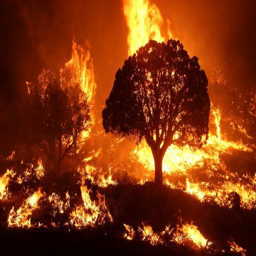

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step


C:\Users\Lenovo/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):



🔥 **Detection Results:**
🔥 Fire detected.


In [13]:
# Upload and Test Image
# Input Image Path
image_path = r"C:\Users\Lenovo\Downloads\Burnout_ops_on_Mangum_Fire_McCall_Smokejumpers.jpg"  # Update with actual image path

if os.path.exists(image_path):
    image = Image.open(image_path).resize((256, 256))
    display(image)

    # Run detection
    fire_prediction = detect_fire(image)
    animal_detected = contains_animal(image)

    # Display Results
    print("\n🔥 **Detection Results:**")
    if fire_prediction < 0.5 and animal_detected:
        print("🔥 Fire detected near animals!")
    elif fire_prediction < 0.5:
        print("🔥 Fire detected.")
    elif animal_detected:
        print("🐾 Animals detected but no fire.")
    else:
        print("✅ No fire or animals detected.")
else:
    print("Image file not found. Please check the path.")
